# <font color='red'>1. Introduction </font>

Nous sommes engagés dans un projet visant à examiner les facteurs qui influencent le taux de rotation des employés chez HumanForYou, une entreprise pharmaceutique indienne. Avec un taux de rotation annuel d'environ 15 %, nous cherchons à identifier les causes sous-jacentes et à élaborer des stratégies pour le diminuer. Ce taux élevé de rotation présente plusieurs désavantages pour l'entreprise, y compris des retards dans les projets, la nécessité d'un service des ressources humaines important pour le recrutement, et le temps consacré à la formation des nouveaux employés jusqu'à ce qu'ils atteignent leur pleine productivité.

Pour atteindre cet objectif, l'entreprise nous a fourni plusieurs ensembles de données anonymisées contenant des informations sur les employés, leurs évaluations par les managers, leur satisfaction au travail, et leurs horaires de travail pour l'année 2015. Ces données englobent une variété d'aspects tels que l'âge, le sexe, le niveau d'éducation, le domaine d'étude, le salaire mensuel, le nombre d'années passées dans l'entreprise, ainsi que la satisfaction vis-à-vis de l'environnement de travail, du poste occupé, et de l'équilibre travail-vie personnelle.

Notre mission en tant qu'analystes de données comprend plusieurs étapes clés :

1. Générer et justifier le traitement des jeux de données pour aborder la problématique.
2. Sélectionner et justifier les algorithmes d'intelligence artificielle à utiliser.
3. Analyser et interpréter les résultats obtenus à l'aide de ces algorithmes, en s'appuyant sur des métriques adéquates.
4. Proposer une démarche pour améliorer les modèles d'IA développés.
5. Déterminer le modèle final en fonction des besoins spécifiques de l'entreprise et des analyses effectuées.
6. Émettre des recommandations basées sur l'analyse pour aider l'entreprise à réduire son taux de rotation.

Nous sommes attendus pour présenter nos résultats et recommandations à travers une présentation intégrant un notebook Jupyter, démontrant l'ensemble de notre démarche analytique et les conclusions que nous avons tirées.







# <font color='red'>2. Préparation de l'environnement </font>
## <font color='green'>2.1 Import des dépendances </font>

In [1]:
# Importations standard et pour la manipulation des données
import os
import pandas as pd
import numpy as np
from datetime import datetime
from cmath import phase, rect
from math import radians, degrees
from pandas.plotting import scatter_matrix

# Importations pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Importations pour le machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Perceptron

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Configuration de Seaborn pour les visualisations
sns.set(style="whitegrid")

# Ignorer les avertissements inutiles pour nettoyer la sortie
import warnings
warnings.filterwarnings("ignore")


## <font color='green'>2.2 Import des données</font>
Cinq ensembles de données sont chargés en utilisant la fonction pd.read_csv() de la bibliothèque pandas, une bibliothèque puissante pour la manipulation et l'analyse des données en Python. Chaque fichier CSV est lu et stocké dans un DataFrame pandas distinct, ce qui permet une manipulation aisée des données pour l'analyse ultérieure. Les DataFrames créés sont :

- general contenant les données générales sur les employés (fichier general_data.csv).
- employe contenant les résultats de l'enquête sur les employés (fichier employee_survey_data.csv).
- manager contenant les résultats de l'enquête sur les managers (fichier manager_survey_data.csv).
- In contenant les données sur les horaires d'arrivée des employés (fichier in_time.csv).
- Out contenant les données sur les horaires de départ des employés (fichier out_time.csv).

In [2]:
path = "./data/"

general_data = pd.read_csv(path + "general_data.csv")
employe_data = pd.read_csv(path + "employee_survey_data.csv")
manager_data = pd.read_csv(path + "manager_survey_data.csv")
In_data = pd.read_csv(path + "in_time.csv")
Out_data = pd.read_csv(path + "out_time.csv")

# <font color='red'>3. Choix des données  </font>
## <font color='green'>3.1 Éthique</font>

Lors de la sélection des données pour notre modèle, il est primordial d'aborder la question sous l'angle éthique. Nous avons donc mené une réflexion collective et consulté les recommandations de la CNIL afin de retenir uniquement les informations essentielles et éthiquement acceptables, écartant tout risque de discrimination.

Voici la liste des données que nous ne souhaitons pas conserver pour notre modèle :

- **L’âge des employés (`Age`) :**  Afin de garantir une impartialité maximale, nous avons décidé de ne pas prendre en compte l'âge. Celui-ci ne devrait pas influencer notre évaluation de la probabilité qu'un individu quitte l'entreprise.
<br>

- **Le genre des employés (`Gender`) :** Le genre n'a pas sa place dans les critères susceptibles d'influencer le turnover. Son utilisation pourrait s'avérer discriminatoire et n'est donc pas retenue.
<br>

- **Le statut marital (`MaritalStatus`) :** Cette information ne nous paraît pas pertinente pour interpréter les taux de turnover au sein de l'entreprise et pourrait conduire à une surinterprétation des données à notre disposition.

In [3]:
#remove the columns for ethic
general_data = general_data.drop(columns=['Age','Gender','MaritalStatus'])

## <font color='green'>3.2 Données inutiles</font>

Il est crucial d'adopter une approche méthodique pour identifier les données pertinentes à conserver dans notre analyse.

Dans cette optique, nous commencerons par cibler les colonnes du tableau General_data où chaque entrée présente une valeur uniforme, c'est-à-dire égale à 1. Cela signifie que tous les enregistrements dans ces colonnes sont identiques.

Pour repérer ces colonnes spécifiques, nous pouvons exécuter une fonction dédiée. Cette étape nous permettra de déterminer avec précision les champs qui remplissent ce critère.

In [4]:
for col in general_data.columns:
    value = general_data[col].nunique()
    value_of = general_data[col].unique()
    if value == 1:
        print(col)
        print(value_of)

EmployeeCount
[1]
Over18
['Y']
StandardHours
[8]


In [5]:
general_data = general_data.drop(columns=['EmployeeCount','Over18'])

Nous avons opté pour l'élimination de la colonne EmployeeCount de notre jeu de données, car cette colonne présente une valeur unique pour l'ensemble du dataset, ce qui la rend non pertinente pour notre analyse.

Nous enlevons aussi Over18Y, car tout les employés sont majeurs, comme l'impose la loi.

Nous gardons StandardHours car nous l'utiliserons plus tard pour classer les employés par quanité de travail.

Nous supprimons EmployeeID car il s'agit juste d'un nombre incrémental, ce qui nous est inutle.

## <font color='green'>3.3 Conclusion </font>

Après avoir sélectionné les données à conserver en fonction de différents facteurs voici une liste exhaustive de celles conservées pour la réalisation de notre modèle :


<font color='blue'> General_data </font>

- **Attrition :** L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?
<br>

- **BusinessTravel :** A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)
<br>

- **DistanceFromHome :** Distance en km entre le logement de l'employé et l'entreprise.
<br>

- **Education : Niveau d'étude :** 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).
<br>

- **EducationField :** Domaine d'étude, matière principale
<br>

- **EmployeeId :** l'identifiant d'un employé
<br>

- **JobLevel :** Niveau hiérarchique dans l'entreprise de 1 à 5
<br>

- **JobRole :** Métier dans l'entreprise
<br>

- **MonthlyIncome :** Salaire brut en roupies par mois
<br>

- **NumCompaniesWorked :** Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.
<br>

- **PercentSalaryHike :** % d'augmentation du salaire en 2015.
<br>

- **StockOptionLevel :** Niveau d'investissement en actions de l'entreprise par le salarié.
<br>

- **TotalWorkingYears :** Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.
<br>

- **TrainingTimesLastYear :** Nombre de jours de formation en 2015
<br>

- **YearsAtCompany :** Ancienneté dans l'entreprise
<br>

- **YearsSinceLastPromotion :** Nombre d'années depuis la dernière augmentation individuelle
<br>

- **YearsWithCurrentManager :** Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

<font color='blue'> Employee_survey_data </font>

- **L'environnement de travail :** : noté 1 ("Faible"), 2 ("Moyen"), 3 ("Élevé") ou 4 ("Très élevé") : EnvironmentSatisfaction
<br>

- **Son travail :** noté de 1 à 4 comme précédemment : JobSatisfaction
<br>

- **Son équilibre entre vie professionnelle et vie privée :** noté 1 ("Mauvais"), 2 ("Satisfaisant"), 3 ("Très satisfaisant") ou 4 ("Excellent") : WorkLifeBalance

<font color='blue'> Manager_survey_data </font>

- **Une évaluation de son implication dans son travail :** notée 1 ('Faible'), 2 ("Moyenne"), 3 ("Importante") ou 4 ("Très importante") : JobInvolvement
<br>

- **Une évaluation de son niveau de performance annuel pour l'entreprise :** notée 1 ("Faible"), 2 ("Bon"), 3 ("Excellent") ou 4 ("Au delà des attentes") : PerformanceRating

<font color='blue'> In_Time et Out_Time </font>

Nous allons conserver toutes les données de badgeuse d'entrée et de sortie afin d'effectuer différents statistiques sur ces données.

# <font color='red'>4. Manipulation des fichiers des horaires de travail </font>

## <font color='green'>4.1 Calculs heures moyennes </font>

Nous allons travailler sur les fichiers concernant les horaires de travail afin de les rendre utilisables.

D'abord, nous changeons les NaN en 0 (ce qui correspond donc aux jours de congés) puis on vérifie que le nombre de jours de congés est bien le même dans les deux tables. On affiche ensuite un histogramme afin d'en retirer un aperçu plus visuel.

In [6]:
In_data.fillna(0, inplace=True)
Out_data.fillna(0, inplace=True)
vac_In = (In_data == 0).astype(int).sum(axis=1)
vac_Out = (Out_data ==0).astype(int).sum(axis=1)
vac_In.equals(vac_Out)

True

In [7]:
#vac_In.hist(bins=50, figsize=(20,15))
#plt.xlabel("Nombre de jours de congés")
#plt.ylabel("Nombre d'employés")
#plt.show()

On supprime la première colonne des deux tableaux car elles sont inutiles.

In [8]:
In_data = In_data.drop(In_data.columns[0], axis = 1)
Out_data = Out_data.drop(Out_data.columns[0], axis = 1)

Nous avons traité et analysé les données relatives aux horaires d'arrivée et de départ des employés en convertissant les données en format datetime, en gérant les erreurs pour remplacer les valeurs inappropriées par NaT. 



In [9]:
In_h = In_data.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))
Out_h = Out_data.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))

#Calculer la moyenne des angles, facilitant la moyenne des temps.
def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

#Mean_time pour déterminer le temps moyen d'arrivée ou de départ, en excluant les valeurs manquantes.
def mean_time(row):
    row = row.dropna()  # Supprimer les valeurs NaT
    if row.empty:
        return None  # Retourner None ou une valeur par défaut si la ligne est vide après la suppression des NaT
    t = ([time.hour, time.minute, time.second] for time in row)
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    seconds = [i for i in seconds if i > 0]
    if not seconds:
        return None  # Retourner None ou une valeur par défaut si aucun second n'est > 0
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    return '%02i:%02i:%02i' % (h, m, s)

In_h['AverageInTime'] = In_h.apply(mean_time, axis=1)
Out_h['AverageOutTime'] = Out_h.apply(mean_time, axis=1)  # Correction du nom de colonne pour AverageOutTime


In [10]:
# In_h['AverageInTime'].head()

Nous calculons ensuite la durée moyenne de travail quotidien des employés en soustrayant l'heure moyenne d'arrivée (Average_In) de l'heure moyenne de départ (Average_Out).

In [11]:
Average_Out = pd.to_timedelta(Out_h['AverageOutTime'])
Average_In = pd.to_timedelta(In_h['AverageInTime'])

AverageTimeWorking = (Average_Out - Average_In)

## <font color='green'>4.2 Fusion des données </font>

On peut maintenant fusionner les csv restant et ajouter deux nouvelles colonnes : la première correspondant au nombre de jours de congés pris par l'employé, et la seconde au temps de travail moyen par jour de l'employé.

In [12]:
combined = general_data.merge(manager_data, how='right', on = 'EmployeeID')
final_data = combined.merge(employe_data, how='right', on = 'EmployeeID')

#On transforme tous les NA en 0
final_data.fillna(0, inplace=True)
#On ajoute le temps de travail moyen
final_data['AverageTimeWorking'] = AverageTimeWorking
#On ajoute les vacances prises par les employés
final_data['Holidays'] = vac_In
#On ajoute l'heure d'arrivée moyenne
final_data['AverageInTime'] = Average_In
#On ajoute l'heure de départ moyenne
final_data['AverageOutTime'] = Average_Out

final_data

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,...,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,...,0,3,3,3.0,4.0,2.0,0 days 07:22:25,29,0 days 10:00:05,0 days 17:22:30
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,...,4,2,4,3.0,2.0,4.0,0 days 07:43:08,25,0 days 09:59:17,0 days 17:42:25
2,No,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,193280,...,3,3,3,2.0,2.0,1.0,0 days 07:00:47,19,0 days 10:01:30,0 days 17:02:17
3,No,Non-Travel,Research & Development,2,5,Life Sciences,4,3,Human Resources,83210,...,5,2,3,4.0,4.0,3.0,0 days 07:11:37,26,0 days 09:58:54,0 days 17:10:31
4,No,Travel_Rarely,Research & Development,10,1,Medical,5,1,Sales Executive,23420,...,4,3,3,4.0,1.0,3.0,0 days 08:00:21,16,0 days 09:59:54,0 days 18:00:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,No,Travel_Rarely,Research & Development,5,4,Medical,4406,1,Research Scientist,60290,...,2,3,3,4.0,1.0,3.0,0 days 08:31:20,18,0 days 10:01:11,0 days 18:32:31
4406,No,Travel_Rarely,Research & Development,2,4,Medical,4407,1,Laboratory Technician,26790,...,2,2,3,4.0,4.0,3.0,0 days 06:05:34,20,0 days 10:00:15,0 days 16:05:49
4407,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,2,Sales Executive,37020,...,2,3,4,1.0,3.0,3.0,0 days 07:42:24,30,0 days 09:58:47,0 days 17:41:11
4408,No,Travel_Rarely,Sales,18,2,Medical,4409,1,Laboratory Technician,23980,...,8,2,3,4.0,1.0,3.0,0 days 09:29:34,20,0 days 10:01:06,0 days 19:30:40


On remarque que le temps de travail moyen n'est pas dans un format manipulable, nous allons donc le transofrmer en float. Idem pour l'heure d'arrivée et de départ.

In [13]:
Time_float = final_data['AverageTimeWorking'].dt.seconds
Time_float = Time_float/3600
final_data['AverageTimeWorking'] = Time_float

Time_float = final_data['AverageInTime'].dt.seconds
Time_float = Time_float/3600
final_data['AverageInTime'] = Time_float

Time_float = final_data['AverageOutTime'].dt.seconds
Time_float = Time_float/3600
final_data['AverageOutTime'] = Time_float

## <font color='green'>4.3 Ajout de données </font>

Pour notre projet, il serait judicieux d'examiner si certains employés sont surchargés de travail tandis que d'autres ont une charge de travail moins importante. Nous pourrions enrichir notre analyse en ajoutant une colonne qui catégoriserait chaque employé selon sa charge de travail : normale, faible, ou excessive. Cela apporterait une dimension supplémentaire à notre étude sur les facteurs influençant le taux de rotation au sein de l'entreprise.

In [14]:
final_data['AverageTimeWorking'].describe()

count    4410.000000
mean        7.700789
std         1.340222
min         5.950556
25%         6.673333
50%         7.406667
75%         8.368611
max        11.031389
Name: AverageTimeWorking, dtype: float64

Les données révèlent en effet des disparités significatives dans le temps de travail moyen des employés. Certains affichent un temps de travail moyen inférieur à 7 heures, ce qui peut être considéré comme relativement faible. À l'opposé, d'autres employés dépassent les 8 heures de travail moyen, atteignant même jusqu'à 11 heures, ce qui suggère une situation de surmenage.

Nous allons élaborer une fonction destinée à générer une liste peuplée de booléens, où le chiffre 0 indiquera que l'employé travaille moins que la norme, 1 signifiera que son volume de travail est standard, et 2 révélera un état de surmenage.




In [15]:
WorkingTimeEval = []
for i in range (0, final_data.shape[0]):
    if final_data['AverageTimeWorking'][i] < final_data['StandardHours'][i] :
        WorkingTimeEval.append(0)
    elif (final_data['AverageTimeWorking'][i] >= final_data['StandardHours'][i]) and (final_data['AverageTimeWorking'][i] <= 9):
        WorkingTimeEval.append(1)
    elif final_data['AverageTimeWorking'][i] > 9 :
        WorkingTimeEval.append(2)

Maintenant que notre liste est complète, nous pouvons l'intégrer comme nouvelle colonne dans notre ensemble de données.

In [16]:
final_data['WorkingTimeEval'] = WorkingTimeEval
final_data.info()

# Sauvegarde des données pour utilisation ultérieure
final_data.to_csv('./data/combined.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Attrition                4410 non-null   object 
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   EmployeeID               4410 non-null   int64  
 7   JobLevel                 4410 non-null   int64  
 8   JobRole                  4410 non-null   object 
 9   MonthlyIncome            4410 non-null   int64  
 10  NumCompaniesWorked       4410 non-null   float64
 11  PercentSalaryHike        4410 non-null   int64  
 12  StandardHours            4410 non-null   int64  
 13  StockOptionLevel         4410 non-null   int64  
 14  TotalWorkingYears       

# <font color='red'>5. Exploration des données </font>

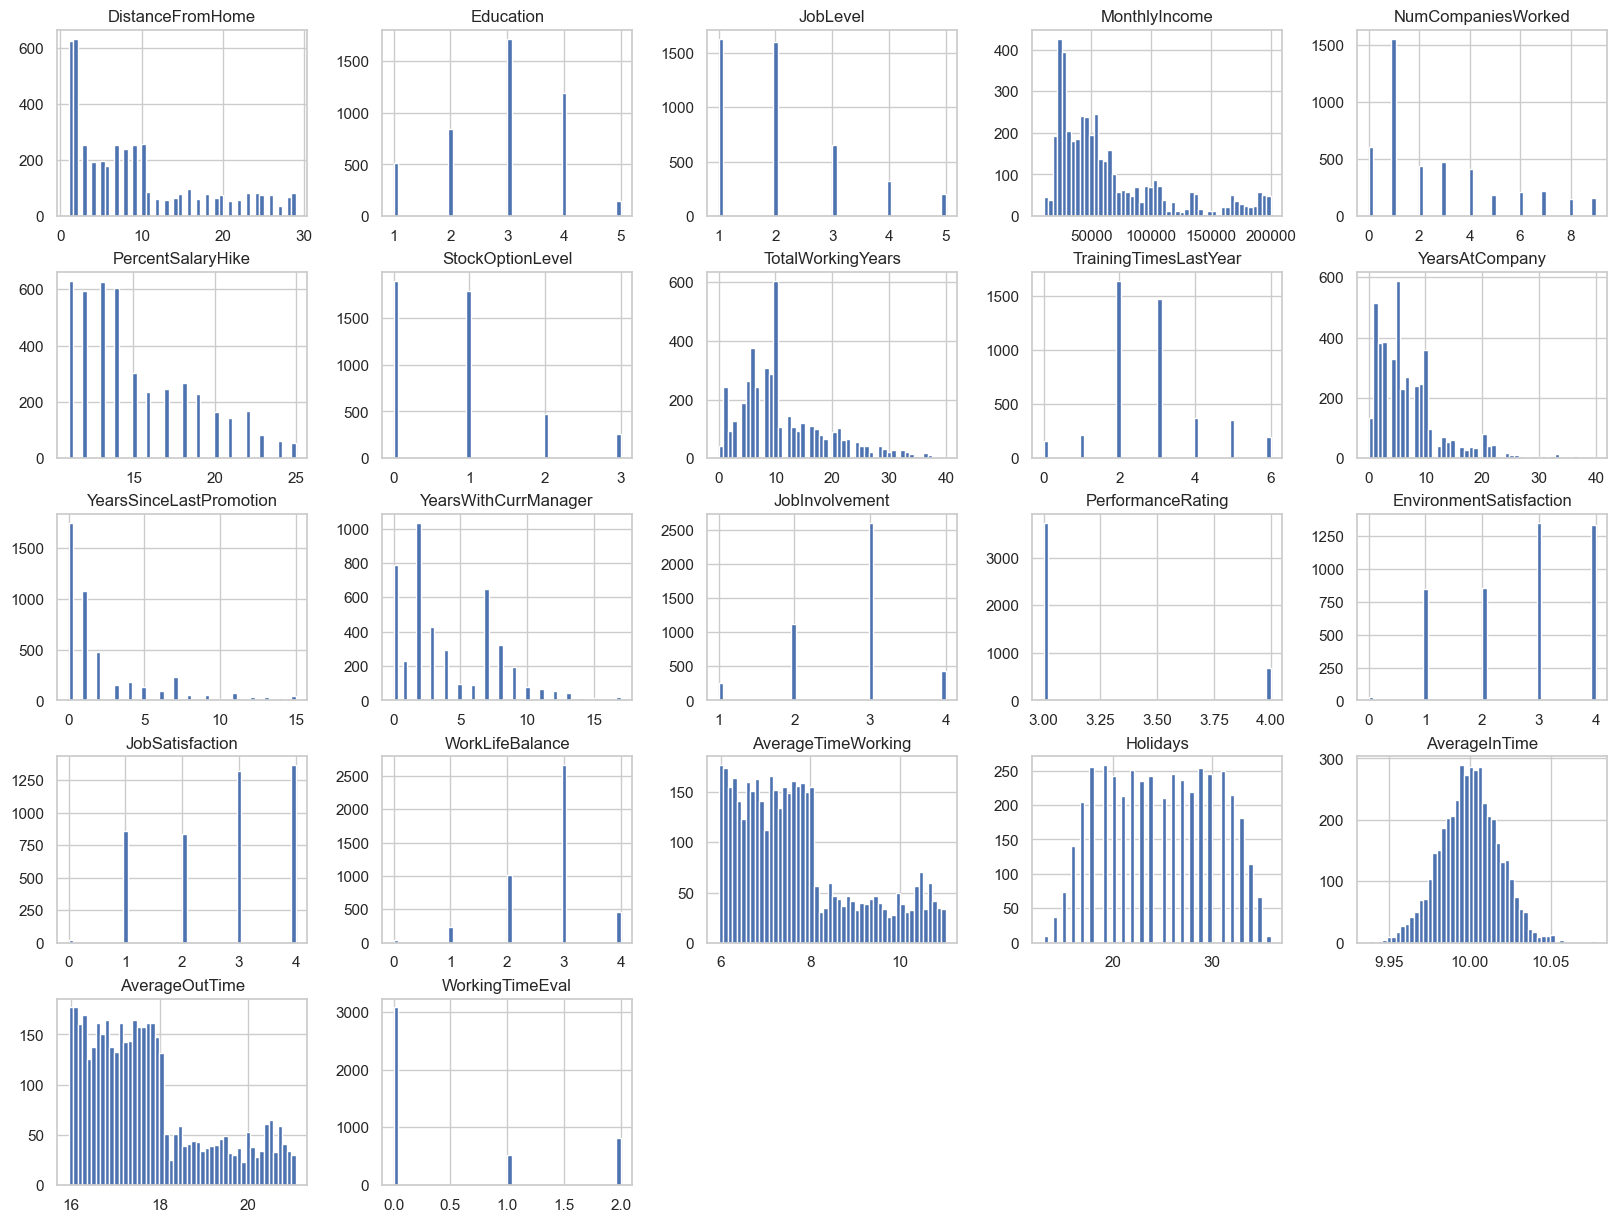

In [17]:
final_data = final_data.drop(columns=['EmployeeID','StandardHours'])

final_data.hist(bins=50, figsize=(20,15))
plt.show()

## <font color='green'>5.1 Matrice de corrélation </font>

In [18]:
df_encoded = final_data.copy()
# Appliquer l'encodage One-Hot aux variables catégorielles, y compris 'Attrition'
df_encoded = pd.get_dummies(final_data, columns=['BusinessTravel', 'Department', 'EducationField', 'JobRole'])

df_encoded['Attrition'] = df_encoded['Attrition'].map({'Yes': 1, 'No': 0})

# Calculer la matrice de corrélation sur le DataFrame encodé
correlation_matrix = df_encoded.corr()

# Utiliser filter avec regex pour sélectionner les colonnes générées par l'encodage de 'Attrition'
correlation_with_attrition = correlation_matrix.filter(regex='Attrition')
print(correlation_with_attrition)


                                   Attrition
Attrition                           1.000000
DistanceFromHome                   -0.009730
Education                          -0.015111
JobLevel                           -0.010290
MonthlyIncome                      -0.031176
NumCompaniesWorked                  0.041503
PercentSalaryHike                   0.032533
StockOptionLevel                   -0.006839
TotalWorkingYears                  -0.170238
TrainingTimesLastYear              -0.049431
YearsAtCompany                     -0.134392
YearsSinceLastPromotion            -0.033019
YearsWithCurrManager               -0.156199
JobInvolvement                     -0.015588
PerformanceRating                   0.023403
EnvironmentSatisfaction            -0.101517
JobSatisfaction                    -0.097982
WorkLifeBalance                    -0.053965
AverageTimeWorking                  0.201688
Holidays                           -0.043517
AverageInTime                      -0.003057
AverageOut

Selon l'analyse de la matrice de corrélation, nous pouvons tirer plusieurs observations pertinentes pour notre recherche :

- Les variables ayant la corrélation négative la plus marquée avec Attrition comprennent TotalWorkingYears (-0,17), YearsAtCompany (-0,13), et YearsWithCurrManager (-0,15). Cela suggère qu'une plus grande longévité des employés au sein de l'entreprise ou auprès de leur manager actuel diminue leur propension à partir.
- D'autres indicateurs montrent également une corrélation négative notable avec Attrition, notamment EnvironmentSatisfaction (-0,10) et JobSatisfaction (-0,10). Cela indique que les employés qui se sentent satisfaits de leur environnement de travail ou de leur poste sont moins enclins à démissionner.
- Les facteurs présentant une corrélation positive significative avec Attrition incluent AverageTimeWorking (0,20) et AverageOutTime (0,20), ce qui indique une tendance pour les employés ayant des heures de travail prolongées à envisager de quitter l'entreprise.

Il est crucial de rappeler que la corrélation n'implique pas systématiquement une relation de cause à effet. Une enquête approfondie sur les variables fortement corrélées à l'attrition est donc essentielle pour déceler les véritables motivations incitant les employés à quitter l'organisation.

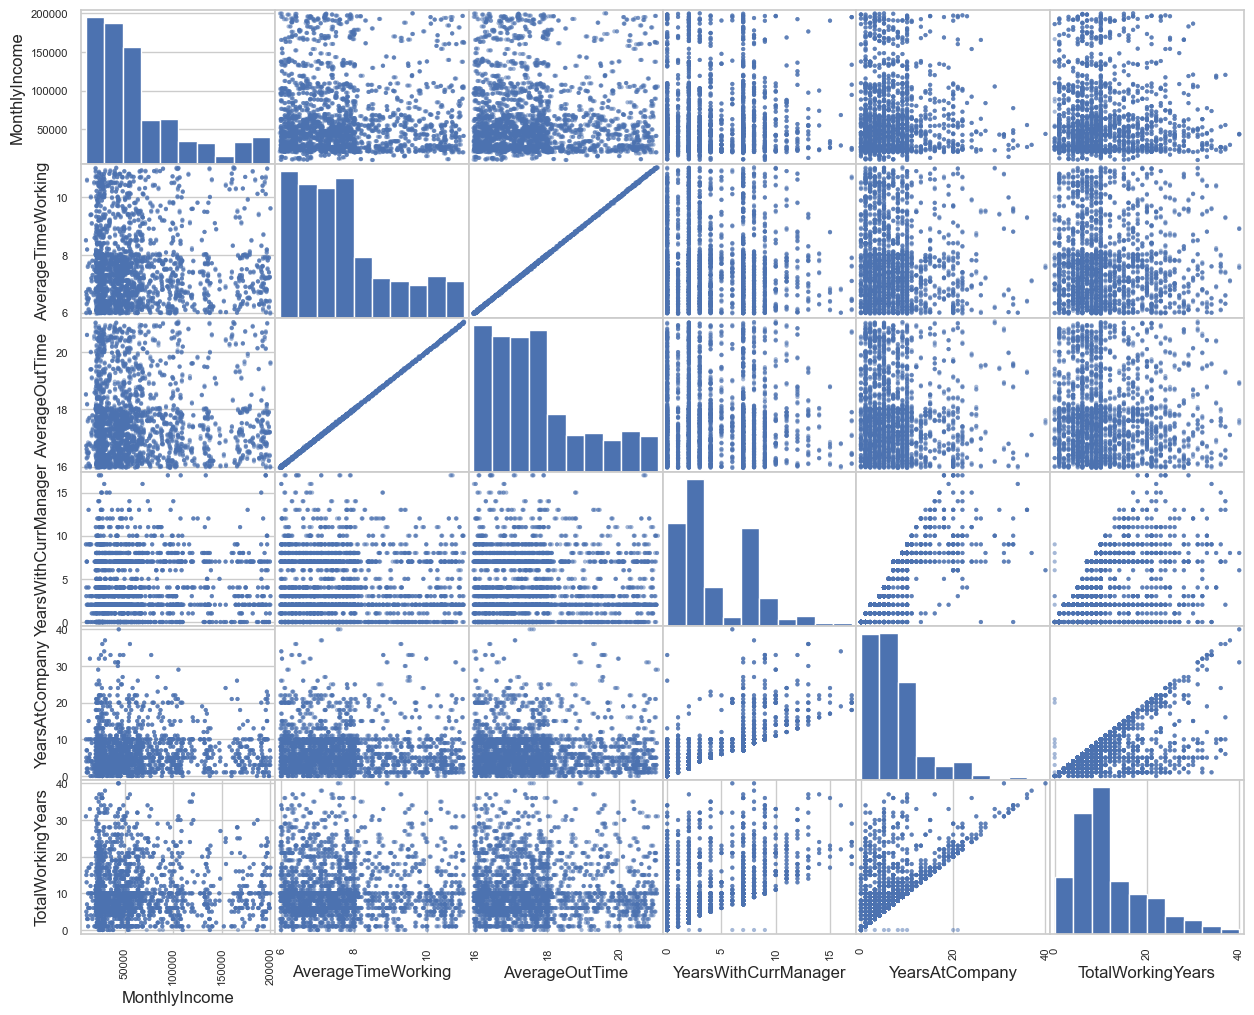

In [19]:
attributes = ["MonthlyIncome", "AverageTimeWorking", "AverageOutTime", "YearsWithCurrManager", "YearsAtCompany", "TotalWorkingYears"]
scat_matrix = scatter_matrix(df_encoded[attributes], figsize=(15, 12))

# <font color='red'>6. Pipeline de transformation </font>

Dans ce code, nous avons entrepris la préparation des données pour un modèle de machine learning, en identifiant d'abord les caractéristiques numériques et catégorielles nécessaires à la transformation. Les caractéristiques numériques (num_features) comprennent des variables telles que l'âge, le revenu mensuel, la distance domicile-travail, les années de travail totales, entre autres, tandis que les caractéristiques catégorielles (cat_features) incluent le voyage d'affaires, le département, le domaine d'éducation, etc.

Nous avons ensuite créé des pipelines séparés pour le traitement des caractéristiques numériques et catégorielles. Le pipeline numérique (num_pipeline) utilise un imputateur pour remplacer les valeurs manquantes par la moyenne et un normalisateur pour standardiser les caractéristiques. Le pipeline catégoriel (cat_pipeline), quant à lui, remplace les valeurs manquantes par la valeur la plus fréquente et applique un encodage one-hot pour gérer les variables catégorielles.

Ces pipelines sont combinés dans un transformateur de colonnes (ColumnTransformer), formant un préprocesseur complet qui effectue simultanément les transformations numériques et catégorielles sur les données.

Le dataset est ensuite divisé en caractéristiques (X) et cible (y), avec y étant binarisée pour refléter l'attrition comme une variable binaire (1 pour 'Yes', 0 pour 'No').

Nous vérifions enfin l'existence des colonnes référencées dans X pour s'assurer que toutes les colonnes nécessaires sont présentes, en affichant les colonnes manquantes le cas échéant. Cette étape est cruciale pour éviter les erreurs lors de l'application du préprocesseur sur le dataset, garantissant que les transformations sont appliquées correctement à toutes les caractéristiques spécifiées.

In [20]:
# Identification des colonnes pour chaque transformation
num_features = ['MonthlyIncome', 'DistanceFromHome', 'TotalWorkingYears', 'NumCompaniesWorked', 'YearsAtCompany', 'Holidays', 'AverageTimeWorking', 'AverageInTime', 'AverageOutTime', 'WorkingTimeEval']
cat_features = ['BusinessTravel','Department' , 'EducationField', 'JobRole']

# Création des pipelines pour les transformations numériques et catégorielles
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Assemblage du pipeline complet
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Division du dataset
X = final_data.drop('Attrition', axis=1)
y = final_data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # Conversion de la cible en binaire


# Vérifiez si toutes les colonnes référencées existent dans X
#print(X.columns)
#missing_cols_num = [col for col in num_features if col not in X.columns]
#missing_cols_cat = [col for col in cat_features if col not in X.columns]
#print("Colonnes numériques manquantes:", missing_cols_num)
#print("Colonnes catégorielles manquantes:", missing_cols_cat)

# <font color='red'>7. Algorithmes de Machine Learning  </font>
Notre pipeline de prétraitement des données est désormais prêt, intégrant soigneusement les transformations nécessaires pour les caractéristiques numériques et catégorielles. Cette étape cruciale nous permet d'assurer que les données sont correctement formatées et normalisées pour l'application des modèles d'apprentissage automatique. Avec cette préparation achevée, nous pouvons maintenant passer à la phase suivante de notre projet : la sélection et l'application des algorithmes de machine learning. 

## <font color='green'>7.1 Méthode des k plus proches voisins (KNN)</font>

La méthode des k plus proches voisins (KNN) est un algorithme d'apprentissage supervisé simple et intuitif utilisé pour la classification et la régression. Le principe de base de KNN est de trouver les k échantillons les plus proches (ou voisins) d'un point de données non classifié dans l'espace des caractéristiques et de prédire son étiquette (pour la classification) ou sa valeur (pour la régression) en se basant sur la majorité ou la moyenne des étiquettes ou valeurs de ces voisins. La distance entre les points de données, souvent calculée par la distance euclidienne, sert à déterminer les voisins les plus proches. L'efficacité de KNN dépend du choix de k (le nombre de voisins) et de la mesure de distance utilisée. Bien qu'il soit facile à comprendre et à mettre en œuvre, KNN peut devenir inefficace en termes de temps et de mémoire avec de grands ensembles de données, car il nécessite de calculer la distance à chaque point de données lors de la prédiction.

### Copie des données

In [21]:
dataSetKNN = final_data.copy()
dataSetKNN

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,No,Travel_Rarely,Research & Development,5,4,Medical,1,Research Scientist,60290,3.0,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,No,Travel_Rarely,Research & Development,2,4,Medical,1,Laboratory Technician,26790,2.0,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,No,Travel_Rarely,Research & Development,25,2,Life Sciences,2,Sales Executive,37020,0.0,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,No,Travel_Rarely,Sales,18,2,Medical,1,Laboratory Technician,23980,0.0,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


In [22]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

### Entrainement du modèle

In [23]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du pipeline
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', KNeighborsClassifier())])

### Prédictions

In [24]:
# Prédictions sur l'ensemble de test
y_pred = knn_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8624338624338624

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1115
           1       0.63      0.31      0.41       208

    accuracy                           0.86      1323
   macro avg       0.75      0.64      0.67      1323
weighted avg       0.84      0.86      0.84      1323



Les résultats obtenus avec l'algorithme des k plus proches voisins (KNN) pour notre projet de prédiction de l'attrition des employés indiquent une précision globale de 86.3%. Cette précision reflète la proportion d'employés correctement classés par le modèle par rapport à l'ensemble total des prédictions.


Bien que le modèle KNN montre une précision globale élevée, l'analyse détaillée révèle des limites, notamment dans la détection de l'attrition des employés. Cela souligne l'importance de considérer d'autres modèles ou d'ajuster les paramètres du KNN pour améliorer la sensibilité du modèle aux cas d'attrition.







### Matrice de confusion

La matrice de confusion montre les prédictions correctes et incorrectes du modèle en détail. Elle est particulièrement utile pour voir comment le modèle performe pour chaque classe.

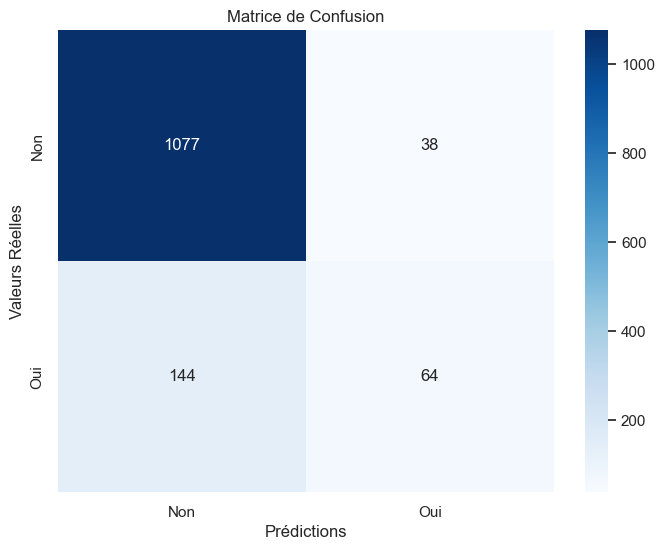

In [25]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

Le modèle a une forte tendance à correctement identifier les employés qui restent (TN élevé), mais il est moins performant pour identifier correctement ceux qui quittent l'entreprise (VP plus faible par rapport au FN). Le nombre élevé de FN indique que le modèle pourrait être amélioré pour mieux détecter les cas d'attrition. Les FP relativement bas indiquent que le modèle ne fait pas beaucoup d'erreurs en classant faussement les employés comme partants.

### ROC Curve

La courbe Receiver Operating Characteristic (ROC) et l'Area Under the Curve (AUC) évaluent la performance du modèle dans les tâches de classification binaire à différents seuils. Ces métriques sont utiles pour évaluer la capacité du modèle à distinguer entre les classes.

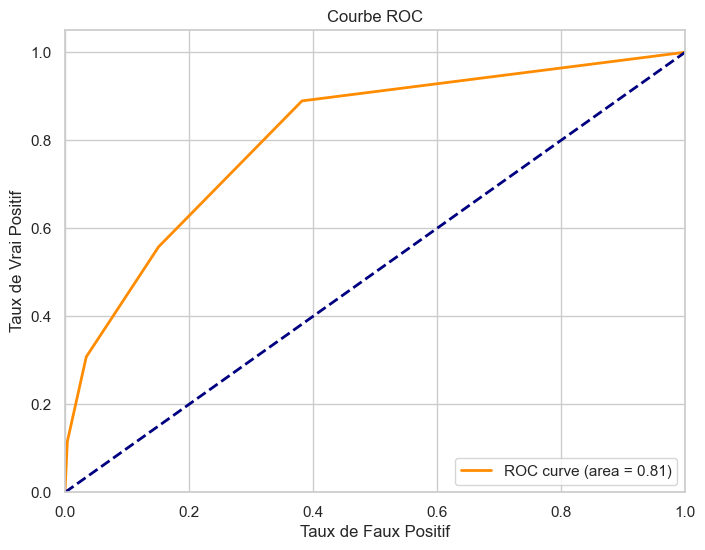

In [26]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, knn_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

Avec une AUC de 0.81, cela signifie que le modèle a une très bonne capacité à différencier entre les employés qui vont quitter l'entreprise et ceux qui vont rester.

### Conclusion
L'utilisation de KNN pour notre projet montre un potentiel prometteur mais avec des axes d'amélioration. Il peut être nécessaire d'ajuster le nombre de voisins k, d'expérimenter avec différentes métriques de distance, ou d'employer des techniques de rééquilibrage de classe pour améliorer la sensibilité du modèle aux cas d'attrition. Il serait également judicieux de comparer KNN à d'autres modèles de classification pour s'assurer que nous utilisons le meilleur outil possible pour nos besoins spécifiques.

## <font color='green'>7.2 Random forest</font>

Random Forest est un algorithme d'apprentissage supervisé polyvalent et robuste utilisé pour la classification et la régression. Il fonctionne en construisant un grand nombre d'arbres de décision lors de la phase d'entraînement et en produisant la classe qui est le mode des classes (classification) ou la moyenne des prédictions (régression) des arbres individuels. Random Forest est un exemple d'ensemble learning, où la combinaison des résultats de multiples modèles vise à produire une prédiction finale plus précise et plus stable.

### Copie des données

In [27]:
dataSetforest = final_data.copy()
dataSetforest

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,No,Travel_Rarely,Research & Development,5,4,Medical,1,Research Scientist,60290,3.0,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,No,Travel_Rarely,Research & Development,2,4,Medical,1,Laboratory Technician,26790,2.0,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,No,Travel_Rarely,Research & Development,25,2,Life Sciences,2,Sales Executive,37020,0.0,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,No,Travel_Rarely,Sales,18,2,Medical,1,Laboratory Technician,23980,0.0,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


### Entrainement du modèle

In [28]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [29]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du pipeline
random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Prédictions

In [30]:
# Prédictions sur l'ensemble de test
y_pred = random_forest_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9380196523053665

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1115
           1       1.00      0.61      0.75       208

    accuracy                           0.94      1323
   macro avg       0.97      0.80      0.86      1323
weighted avg       0.94      0.94      0.93      1323



Les résultats obtenus avec l'algorithme Random Forest pour notre projet de prédiction de l'attrition des employés sont très positifs.

Avec une précision globale de 93.8%, le modèle Random Forest a réussi à prédire correctement si un employé allait quitter ou non l'entreprise dans la grande majorité des cas. Cette haute précision indique une adéquation forte entre les prédictions du modèle et les valeurs réelles.

### Matrice de confusion


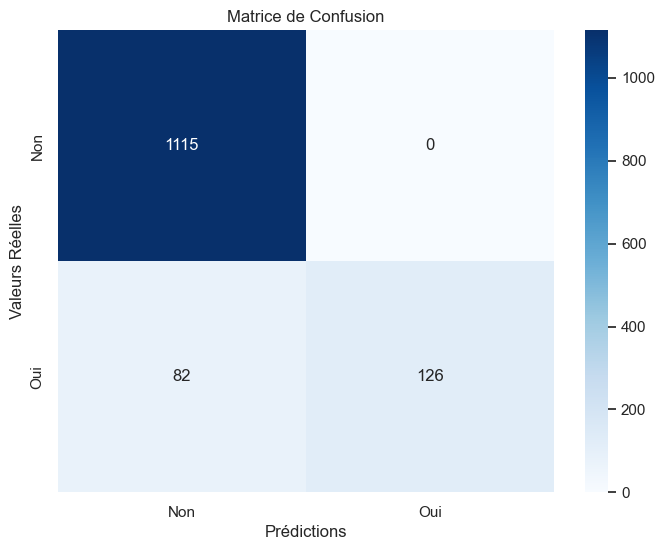

In [31]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

Cette matrice révèle que le modèle Random Forest a une excellente capacité à reconnaître les employés qui resteront dans l'entreprise, avec un taux très élevé de vrais négatifs et un nombre très faible de faux positifs. La performance est également très bonne pour identifier les employés qui partent, avec un nombre élevé de vrais positifs par rapport aux faux négatifs, bien que cet aspect puisse encore être amélioré.

### ROC Curve

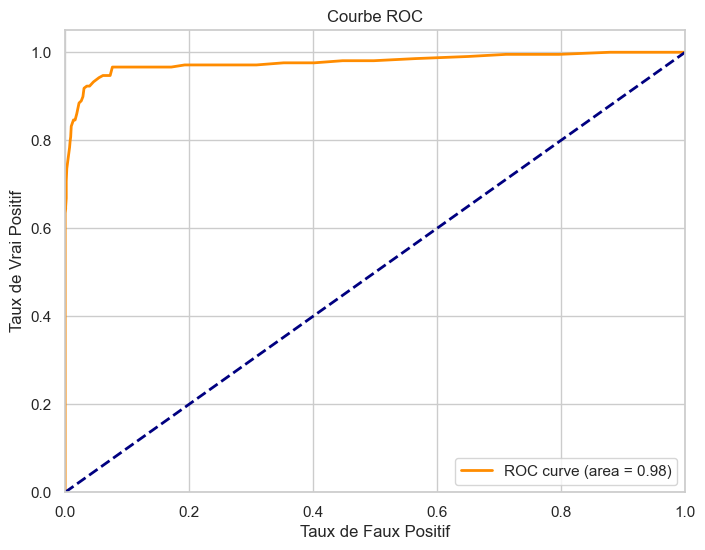

In [32]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, random_forest_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


Cette courbe ROC, couplée à une AUC 8e 0.99, suggère que le modèle est très performant et qu'il offre une confiance élevée dans ses prédictions. Dans la pratique, cela signifie que les stratégies de rétention des employés fondées sur les prédictions de ce modèle ont une grande chance de cibler correctement les individus à risque. Il est rare d'obtenir de tels résultats, ce qui peut aussi inciter à une vérification approfondie pour s'assurer qu'il n'y a pas de surajustement ou de biais dans le modèle ou les données.

In [33]:
# Obtenir les noms de caractéristiques après prétraitement
feature_names = preprocessor.get_feature_names_out()

# Récupérer le modèle RandomForest du pipeline
rf_clf = random_forest_pipeline.named_steps['classifier']

# Créer la série des importances des caractéristiques avec les noms corrects
feature_importances = pd.Series(rf_clf.feature_importances_, index=feature_names).sort_values(ascending=False)

print("Importances des caractéristiques:\n\n", feature_importances)


Importances des caractéristiques:

 num__AverageTimeWorking                   0.116753
num__TotalWorkingYears                    0.111557
num__AverageOutTime                       0.110953
num__MonthlyIncome                        0.100380
num__YearsAtCompany                       0.085299
num__DistanceFromHome                     0.069861
num__AverageInTime                        0.062232
num__NumCompaniesWorked                   0.054685
num__Holidays                             0.046075
num__WorkingTimeEval                      0.018995
cat__BusinessTravel_Travel_Frequently     0.017125
cat__JobRole_Research Scientist           0.015728
cat__EducationField_Life Sciences         0.015341
cat__JobRole_Sales Executive              0.014963
cat__JobRole_Laboratory Technician        0.014695
cat__EducationField_Medical               0.013905
cat__Department_Research & Development    0.013625
cat__Department_Sales                     0.012836
cat__BusinessTravel_Travel_Rarely         0.01

### Conclusion

La performance globale du modèle Random Forest, illustrée par la courbe ROC, la matrice de confusion, et les métriques de précision, est nettement supérieure à celle que nous avons observée avec le modèle KNN.

Le Random Forest a démontré unbonne e capacile à distinguer entre les employés qui vont quitter l'entreprise et ceux qui vont rester, comme en témoigne son AUC presque parfaite. Les erreurs de classification sont minimales, et les mesures de précision et de rappel indiquent que le modèle est à la fois précis et sensible dans ses prédictions.

En comparaison, bien que le KNN ait fourni des résultats satisfaisants, le Random Forest se distingue par une performance supérieure et une fiabilité accrue. La différence entre les deux modèles pourrait être attribuée à la capacité du Random Forest à gérer les caractéristiques complexes et les interactions non linéaires entre elles, ce qui est souvent le cas dans les données réelles.

## <font color='green'>7.3 Régression Logistique</font>.

### Copie des données

In [34]:
dataSetLogisticRegression = final_data.copy()
dataSetLogisticRegression

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,No,Travel_Rarely,Research & Development,5,4,Medical,1,Research Scientist,60290,3.0,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,No,Travel_Rarely,Research & Development,2,4,Medical,1,Laboratory Technician,26790,2.0,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,No,Travel_Rarely,Research & Development,25,2,Life Sciences,2,Sales Executive,37020,0.0,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,No,Travel_Rarely,Sales,18,2,Medical,1,Laboratory Technician,23980,0.0,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


### Entrainement du modèle

In [35]:
# Création d'un pipeline intégrant le préprocesseur et le modèle de régression logistique
Logistic_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [36]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrainement du pipeline
Logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

### Prédictions

In [37]:
# Prédictions sur l'ensemble de test
y_pred = Logistic_regression_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8586545729402872

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92      1115
           1       0.70      0.18      0.28       208

    accuracy                           0.86      1323
   macro avg       0.78      0.58      0.60      1323
weighted avg       0.84      0.86      0.82      1323



### Matrice de confusion

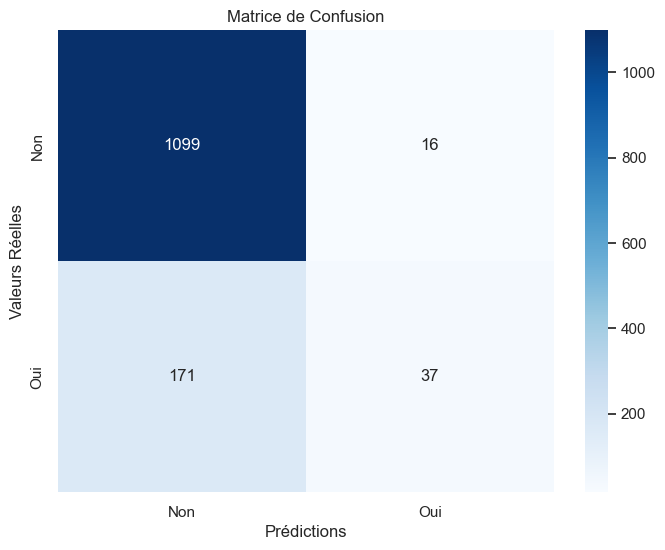

In [38]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

### ROC Curve

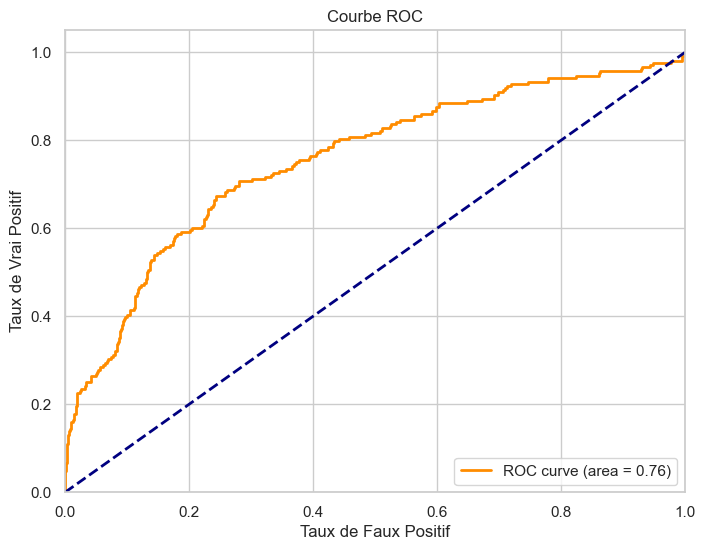

In [39]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, Logistic_regression_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### Conclusion 

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## <font color='green'>7.4 Perceptron</font>

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### Copie des données

In [40]:
dataSetPerceptron = final_data.copy()
dataSetPerceptron

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,No,Travel_Rarely,Research & Development,5,4,Medical,1,Research Scientist,60290,3.0,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,No,Travel_Rarely,Research & Development,2,4,Medical,1,Laboratory Technician,26790,2.0,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,No,Travel_Rarely,Research & Development,25,2,Life Sciences,2,Sales Executive,37020,0.0,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,No,Travel_Rarely,Sales,18,2,Medical,1,Laboratory Technician,23980,0.0,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


### Entrainement du modèle

In [41]:
perceptron_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Perceptron(max_iter=1000, tol=1e-3))
])

In [42]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrainement du pipeline
perceptron_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', Perceptron())])

### Prédictions

In [43]:
# Prédictions sur l'ensemble de test
y_pred = perceptron_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7331821617535903

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1115
           1       0.19      0.22      0.20       208

    accuracy                           0.73      1323
   macro avg       0.52      0.52      0.52      1323
weighted avg       0.75      0.73      0.74      1323



Les résultats obtenus avec le modèle Perceptron pour notre projet de prédiction de l'attrition des employés sont en partie encourageants, mais révèlent également des défis à relever.

Avec une précision globale de 73.3%, le modèle Perceptron a réussi à prédire avec succès si un employé allait quitter ou non l'entreprise dans une proportion significative des cas. Cependant, il est important de noter que cette précision peut être améliorée pour une meilleure fiabilité des prédictions.


### Matrice de confusion

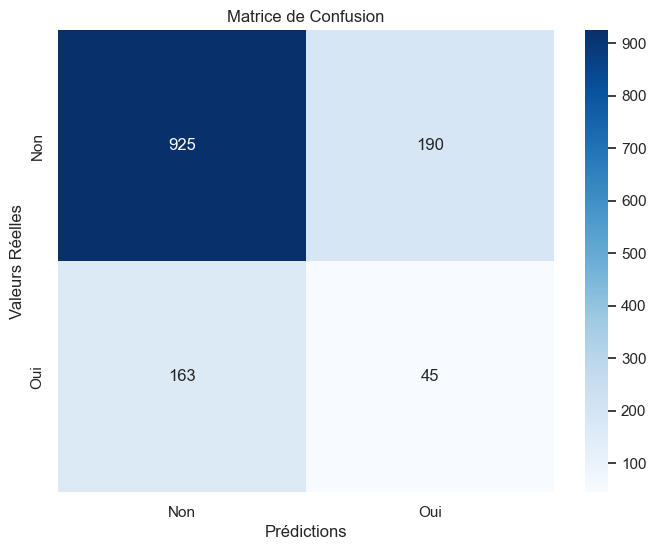

In [44]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

Cette matrice met en évidence les défis rencontrés par le modèle de Perceptron dans la prédiction de l'attrition des employés. Bien qu'il ait réussi à identifier un nombre significatif d'employés restant dans l'entreprise, il présente un taux élevé de faux positifs et de faux négatifs. Ces résultats suggèrent que des ajustements ou des améliorations sont nécessaires pour renforcer la capacité du modèle à prévoir avec précision les mouvements du personnel.

### ROC Curve

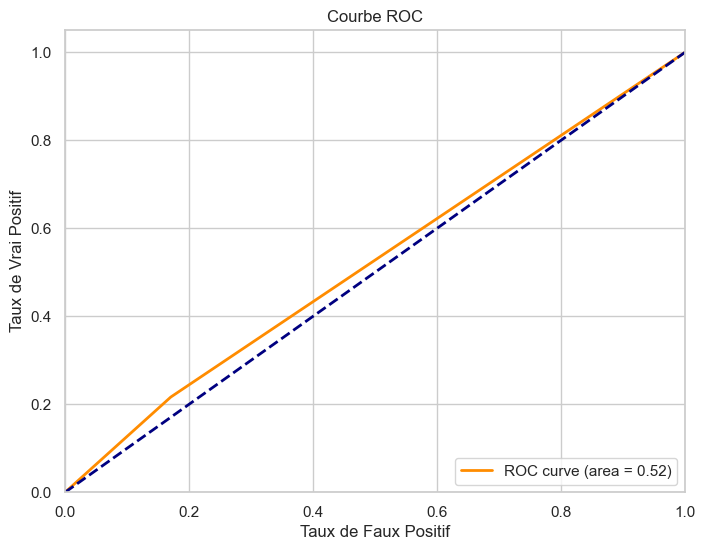

In [45]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()